# Code-Executing Chatbot for Data Analysis

## Overview
This workflow uses **LangChain** and **Google's Gemini API** to create a chatbot that processes CSV data, executes Python code, and generates visualizations.

**Key Features:**
- Real-time code execution for data analysis
- Multi-turn conversations with context preservation
- Inline visualization display and file saving
- CSV data processing (200 rows for demo efficiency)

## Use Cases
Perfect for various data analysis scenarios:
- **Business Intelligence**: Analyze sales performance, customer trends, and revenue patterns
- **Academic Research**: Process survey data, experimental results, and statistical analysis
- **Financial Analysis**: Examine market trends, portfolio performance, and risk assessment
- **Marketing Analytics**: Evaluate campaign effectiveness, customer segmentation, and ROI
- **Operations Research**: Optimize workflows, analyze productivity metrics, and resource allocation
- **Educational Tool**: Interactive data science learning with immediate visual feedback

## Dataset
Uses **Sample Sales Data** from [Kaggle](https://www.kaggle.com/datasets/kyanyoga/sample-sales-data) with columns:
- **Order Info**: `ORDERNUMBER`, `ORDERDATE`, `STATUS`
- **Sales**: `SALES`, `QUANTITYORDERED`, `PRICEEACH`
- **Customer**: `CUSTOMERNAME`, `COUNTRY`, `TERRITORY`
- **Time**: `MONTH_ID`, `YEAR_ID`

## Setup Requirements
1. **Google Gemini API Key**: Get from [Google AI Studio](https://aistudio.google.com/)
2. **Dataset**: Download CSV from [Kaggle](https://www.kaggle.com/datasets/kyanyoga/sample-sales-data)
3. **Libraries**: LangChain, Pandas, PIL, matplotlib

## Import Libraries
Essential dependencies for the AI-powered data analysis workflow:
- **LangChain**: For Gemini API integration and message handling
- **Pandas**: CSV data processing and manipulation
- **PIL/matplotlib**: Image processing and display
- **IPython.display**: Inline visualization in notebooks

In [1]:
import base64
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.callbacks import StreamingStdOutCallbackHandler
import pandas as pd
from PIL import Image
import io
import matplotlib.pyplot as plt
from IPython.display import display

## CSV Data Processing
Handles CSV file loading and conversion to AI-processable text format. The function reads CSV files with robust encoding support and converts them to string format that can be embedded directly in AI messages.

**Key Features:**
- Uses first 200 rows for demo efficiency and faster processing
- Handles encoding issues with latin-1 fallback
- Converts DataFrame to CSV text format for AI consumption

In [30]:
def load_csv_as_text(csv_path: str) -> str:
    """Load CSV file (first 200 rows) and convert to text."""
    print(f"Loading {csv_path}...")
    df = pd.read_csv(csv_path, encoding='latin-1').head(200)
    print(f"Loaded {df.shape[0]} rows, {df.shape[1]} columns")
    return df.to_csv(index=False)

## LLM Setup
Initializes the Google Gemini 2.5 Flash model with code execution capabilities. This setup enables the AI to generate and execute Python code for data analysis and visualization.

**Configuration:**
- **Model**: Gemini 2.5 Flash for fast responses
- **Streaming**: Real-time output display
- **Code Execution**: Enabled for dynamic analysis and chart generation

Replace `your-api-key` with your actual API key from Google AI Studio.

In [ ]:
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    callbacks=[StreamingStdOutCallbackHandler()],
    google_api_key="your-api-key"  # Replace with your actual API key
).bind_tools([{"code_execution": {}}])

## Message Construction
Creates structured messages for multi-turn conversations with CSV data embedding. This function builds the proper message format required by LangChain for Gemini API interactions.

**Functionality:**
- Combines user queries with CSV data in structured format
- Maintains conversation history for context preservation
- Supports both initial queries and follow-up questions

In [32]:
def create_analysis_message(query: str, csv_content: str = None, previous_messages: list = None) -> list:
    messages = previous_messages or []
    content = [{"type": "text", "text": query}]
    if csv_content:
        content.append({
            "type": "text",
            "text": f"Dataset (CSV):\n{csv_content}"
        })
    messages.append(HumanMessage(content=content))
    return messages

## Response Processing
Extracts and separates text content and base64-encoded images from AI responses. Gemini's code execution can generate both textual analysis and visual outputs that need different handling.

**Processing Steps:**
- Parses complex response structure from Gemini
- Extracts base64 image data when present
- Returns separated content for display and saving

In [33]:
def process_response(response) -> tuple:
    """Extract text content and base64 images from Gemini response."""
    content = response.content
    image_base64 = None
    
    for item in content:
        if isinstance(item, dict) and item.get('type') == 'image_url':
            image_base64 = item['image_url']['url'].split(',')[1]  # Extract base64
    return content, image_base64

## Main Workflow
Orchestrates the complete data analysis workflow from data loading through final visualization. This function coordinates all components to create a seamless multi-turn conversation experience.

**Workflow Steps:**
1. **Data Loading**: Load and prepare CSV data for AI processing
2. **Initial Analysis**: Send first query with data to generate insights
3. **Context Management**: Add AI response to conversation history
4. **Follow-up Query**: Process refinement requests with maintained context
5. **Visualization**: Display charts inline and save as PNG files

**Output Management:**
- Displays images directly in notebook cells for immediate viewing
- Saves charts as PNG files for external use and sharing

In [34]:
def run_data_analysis_chatbot(initial_query: str, csv_path: str, follow_up_query: str) -> dict:
    print("Starting AI Data Analysis Chatbot")
    print("=" * 40)
    
    # Load and prepare data
    print("\nStep 1: Loading data...")
    csv_content = load_csv_as_text(csv_path) if csv_path else None
    print("Data preparation complete")
    
    # Initial analysis
    print(f"\nStep 2: Processing initial query...")
    print(f"Query: {initial_query}")
    messages = create_analysis_message(initial_query, csv_content)
    print("Sending request to Gemini AI...")
    initial_response = llm.invoke(messages)
    print("Response received, processing...")
    initial_content, initial_image = process_response(initial_response)
    
    if initial_image:
        try:
            image_data = base64.b64decode(initial_image)
            image = Image.open(io.BytesIO(image_data))
            display(image)
            image.save("initial_analysis_plot.png")
            print("✓ Initial chart displayed and saved as initial_analysis_plot.png")
        except Exception as e:
            print(f"Error processing initial image: {e}")
    else:
        print("✓ Initial analysis complete (no chart generated)")
    
    # Add to conversation history
    messages.append(AIMessage(content=initial_content))
    
    # Follow-up analysis
    print(f"\nStep 3: Processing follow-up query...")
    print(f"Query: {follow_up_query}")
    messages = create_analysis_message(follow_up_query, previous_messages=messages)
    print("Sending follow-up request...")
    follow_up_response = llm.invoke(messages)
    print("Follow-up response received, processing...")
    follow_up_content, follow_up_image = process_response(follow_up_response)
    
    if follow_up_image:
        try:
            image_data = base64.b64decode(follow_up_image)
            image = Image.open(io.BytesIO(image_data))
            display(image)
            image.save("final_analysis_plot.png")
            print("✓ Final chart displayed and saved as final_analysis_plot.png")
        except Exception as e:
            print(f"Error processing follow-up image: {e}")
    else:
        print("✓ Follow-up analysis complete (no chart generated)")
    
    print("\n🎉 Analysis Complete!")
    return {
        "initial_response": initial_content,
        "follow_up_response": follow_up_content
    }

## Execute Workflow
Demonstrates the complete chatbot capabilities with a two-step sales data analysis workflow. This example showcases how the AI maintains context between queries and iteratively refines visualizations.

**Demo Workflow:**
1. **Initial Query**: "Analyze sales trends and create line chart"
   - Processes 200-row sample of sales data
   - Generates comprehensive trend analysis
   - Creates initial line chart visualization

2. **Follow-up Query**: "Highlight top months in red"
   - Builds upon previous analysis using conversation context
   - Modifies existing chart with highlighted data points
   - Demonstrates iterative visualization refinement

**Technical Features:**
- **Efficient Processing**: Uses 200-row sample for faster response times
- **Dual Output**: Charts displayed inline + saved as PNG files
- **Context Preservation**: Maintains conversation state across queries

Demo Configuration:
Dataset: sample_sales_data.csv
Initial: Analyze the sales trends and plot monthly sales as a line chart.
Follow-up: Highlight the top-performing months in red on the chart.
Starting AI Data Analysis Chatbot

Step 1: Loading data...
Loading sample_sales_data.csv...
Loaded 200 rows, 25 columns
Data preparation complete

Step 2: Processing initial query...
Query: Analyze the sales trends and plot monthly sales as a line chart.
Sending request to Gemini AI...
Response received, processing...
Response received, processing...


/Users/muhammadsaad/Documents/OpenSource/langchain-google/libs/genai/langchain_google_genai/chat_models.py:686: UserWarning: 
        ⚠️ Warning: Output may vary each run.  
        - 'executable_code': Always present.  
        - 'execution_result' & 'image_url': May be absent for some queries.  

        Validate before using in production.

  warnings.warn(


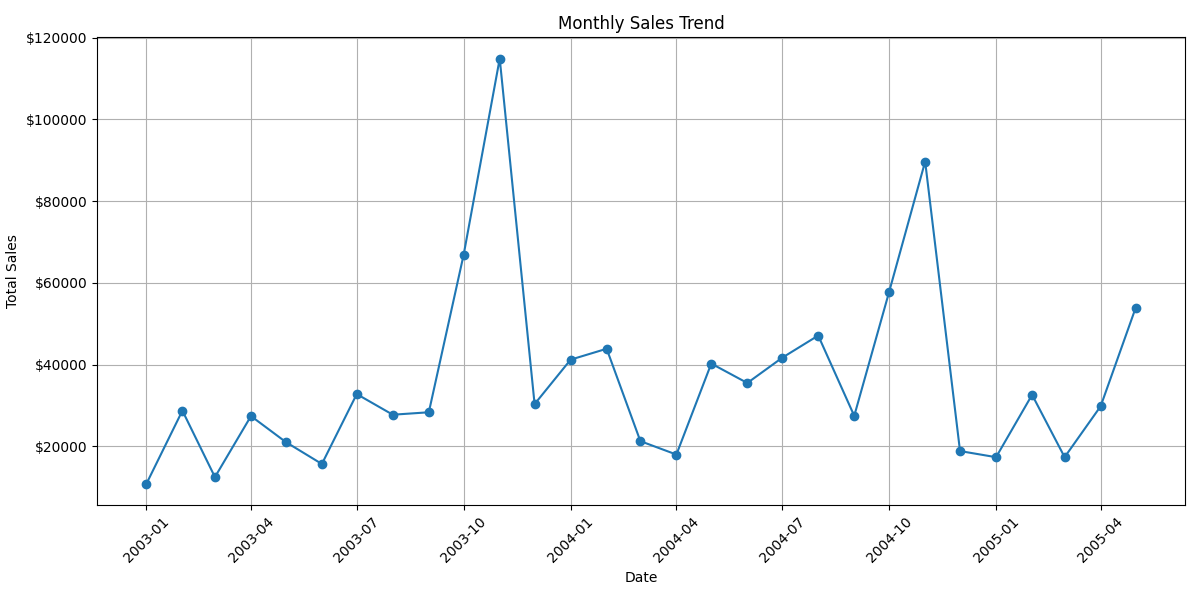

✓ Initial chart displayed and saved as initial_analysis_plot.png

Step 3: Processing follow-up query...
Query: Highlight the top-performing months in red on the chart.
Sending follow-up request...
Follow-up response received, processing...
Follow-up response received, processing...


/Users/muhammadsaad/Documents/OpenSource/langchain-google/libs/genai/langchain_google_genai/chat_models.py:686: UserWarning: 
        ⚠️ Warning: Output may vary each run.  
        - 'executable_code': Always present.  
        - 'execution_result' & 'image_url': May be absent for some queries.  

        Validate before using in production.

  warnings.warn(


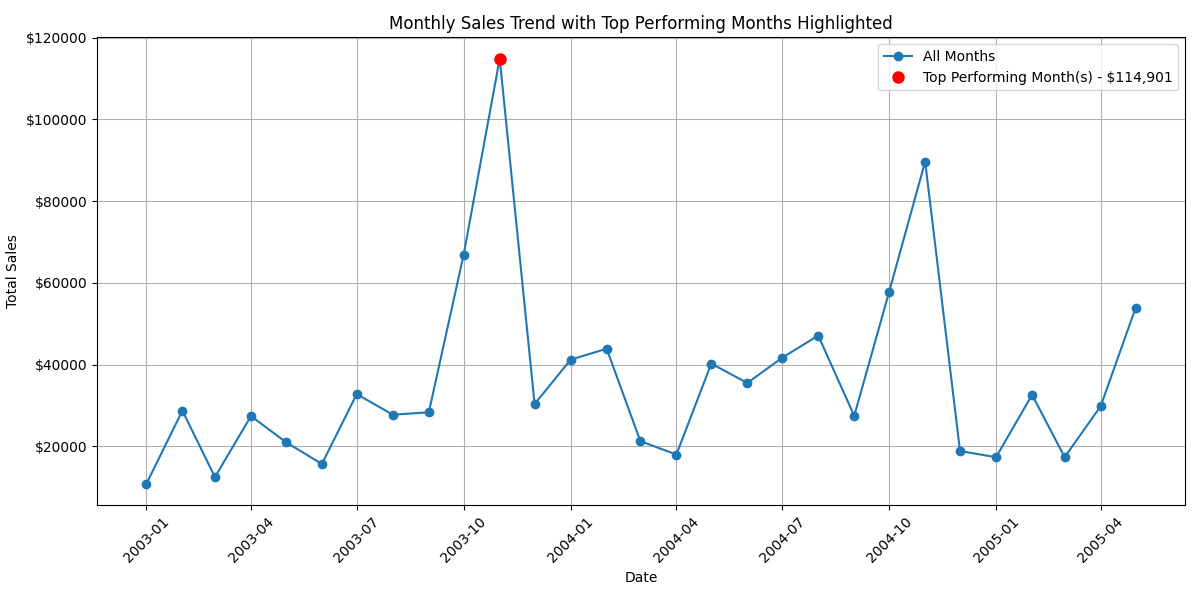

✓ Final chart displayed and saved as final_analysis_plot.png

🎉 Analysis Complete!


In [35]:
if __name__ == "__main__":
    # Configuration
    initial_query = "Analyze the sales trends and plot monthly sales as a line chart."
    follow_up_query = "Highlight the top-performing months in red on the chart."
    csv_path = "sample_sales_data.csv"
    
    print("Demo Configuration:")
    print(f"Dataset: {csv_path}")
    print(f"Initial: {initial_query}")
    print(f"Follow-up: {follow_up_query}")
    
    # Execute workflow
    result = run_data_analysis_chatbot(initial_query, csv_path, follow_up_query)